In [2]:
import matplotlib.pyplot as plt
import random
import time

In [3]:
import sys
print (sys.executable)

/home/victor/blaarkop/.venv/bin/python


In [4]:
def read_bin0(filename):

    with open(filename, 'rb') as binfile:
        bs =  binfile.read()
        return len(bs)
    return 0

In [5]:
K = 1000
NS = [ 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 30000, 40000, 50000 ]
filenames = {N: f'random_bytes_{N}Kb.bin' for N in NS }


In [6]:
if False:
    # Create new binary files
    for N in filenames:    
        fname = filenames[N]
        bs = bytes(list(random.randint(0,0xFF) for b in range(N * K)))
        print(f'{fname}: {bs[:20]}')
        with open(fname, 'wb') as binfile:
            binfile.write(bs)

In [7]:
def measure_time_ns(runs, procfunc, *args):
    total = 0
    for i in range(runs):
        # try if file can be read (also removes IO noise from measurements)
        _ = procfunc(*args)

        # start measurement
        t0 = time.time_ns()
        _ = procfunc(*args)
        total += time.time_ns() - t0
        
    return total // runs

In [8]:
def experiment(runs, procfunc, filenames):
    print(f'runs={runs}, name={procfunc.__name__}')
    return { N : measure_time_ns(runs, procfunc, filenames[N]) / 10E9 for N in filenames }


In [9]:
def plot_experiments(exps):
    fig, ax = plt.subplots()
    fig.suptitle("Average time")
    for expname in exps:
        times = exps[expname]
        ax.scatter(times.keys(), times.values(), marker='.', label=expname)
        plt.xlabel('File size [Kb]')
        plt.ylabel('Time [s]')
        plt.legend()


In [10]:
exps = dict()

In [11]:
def add_experiment(runs, procfunc, *args):
    global exps
    exps[procfunc.__name__] = experiment(runs, procfunc, *args)

In [12]:
add_experiment(7, read_bin0, filenames)

runs=7, name=read_bin0


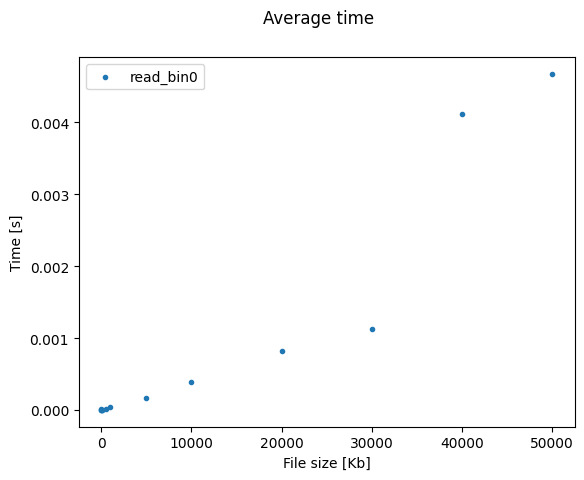

In [13]:
plot_experiments(exps)

In [14]:
def packet_size(b0b1: bytes):
    # b0b1: 2 byte integer in little endian order
    return (0x100 * b0b1[1] + b0b1[0]) % 512

In [15]:
def parse_packets0(fname):
    num = 0    
    with open(fname, 'rb') as binfile:
        while True:
            b0b1 = binfile.read(2)
            hsize = len(b0b1)
            if hsize != 2:
                break
            plen = packet_size(b0b1)
            packet = binfile.read(plen)
            psize = len(packet)
            if psize != plen:
                break
            num += 1
    return num

In [16]:
add_experiment(7, parse_packets0, filenames)

runs=7, name=parse_packets0


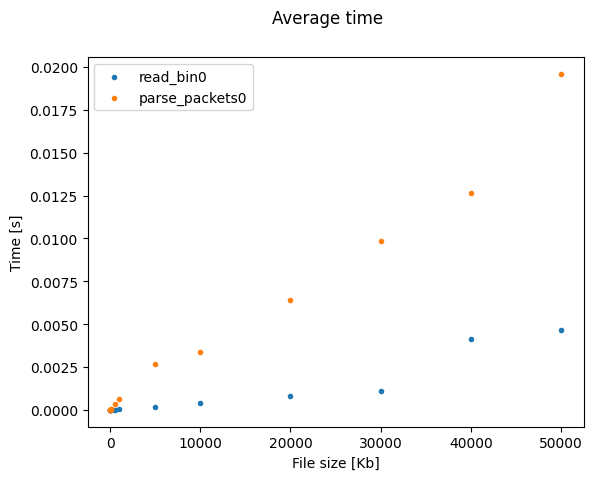

In [17]:
plot_experiments(exps)

In [18]:
def compute_CRC(bs: bytes) -> bytes:
    crc0 = 0
    crc1 = 0
    for b in bs:
        crc0 = (crc0 | b)
        crc1 = (crc1 | crc0)
    return (crc0, crc1)

In [19]:
def parse_packets1(fname):
    num = 0    
    with open(fname, 'rb') as binfile:
        while True:
            b0b1 = binfile.read(2)
            hsize = len(b0b1)
            if hsize != 2:
                break
            plen = packet_size(b0b1)
            packet = binfile.read(plen)
            psize = len(packet)
            if psize != plen:
                break
            crc = compute_CRC(packet)
            num += 1
    return num

In [20]:
add_experiment(7, parse_packets1, { N : filenames[N] for N in filenames if N<51000})

runs=7, name=parse_packets1


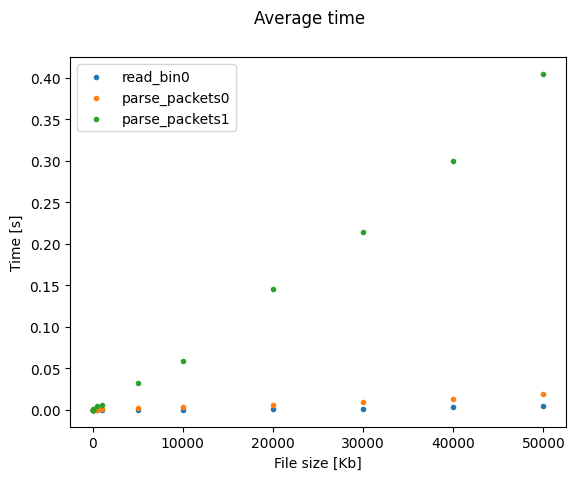

In [21]:
plot_experiments(exps)